# Regression Part 1: 
## Using All Pitchfork Data

In [1]:
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split, KFold
from sklearn import feature_selection as f_select
from sklearn.cross_validation import cross_val_score
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from datetime import datetime as dt
#sns.set_style("darkgrid")
sns.set_style("whitegrid")
sns.set_palette("RdBu", n_colors=7)
%pylab inline

import warnings
warnings.filterwarnings('ignore')

/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load the pickled dataframe

In [92]:
with open("review2_2_df.pkl", 'rb') as picklefile: 
    df = pickle.load(picklefile)

In [3]:
df.head()

,album,artist,author,author_title,bnm,genre,label,score,word_count,year,pub_date_x_x,author_review_count,total_number_releases,release_number,cum_mean_score,review_number,cum_mean_score_author,spotify_popularity
0,Their Satanic Majesties Request,The Rolling Stones,Stephen Thomas Erlewine,Contributor,None,Rock,ABKCO,7.8,1409,1967,2017-09-23 05:00:00,18,5,5,8.020000,18,8.072222,NaN
1,Elastica,Elastica,Judy Berman,Contributor,None,Rock,Deceptive,8.5,2304,1995,2017-09-24 05:00:00,4,1,1,NaN,4,8.175000,44.0
2,Living Water,Shannon Lay,Philip Sherburne,Contributing Editor,None,Folk/Country,Woodsist,7.8,1091,2017,2017-09-25 05:00:00,256,1,1,NaN,255,7.550781,41.0
3,Aromanticism,Moses Sumney,Jason King,Contributor,Best new music,Pop/R&B,Jagjaguwar,8.6,842,2017,2017-09-27 05:00:00,1,2,2,8.000000,1,NaN,64.0
4,Brand New Abyss,The Blow,Brian Howe,Contributor,None,Pop/R&B,Self-released,5.8,794,2017,2017-09-21 05:00:00,497,6,6,6.883333,497,7.059155,45.0


In [4]:
df.describe()

,score,word_count,author_review_count,total_number_releases,release_number,cum_mean_score,review_number,cum_mean_score_author,spotify_popularity
count,18218.00000,18218.000000,18218.000000,18218.000000,18218.000000,9515.000000,18218.000000,17759.000000,16924.000000
mean,7.01818,662.588374,239.672741,4.126468,2.562850,7.167176,120.335492,6.962325,40.241964
std,1.26974,243.943871,218.342154,4.052509,2.608133,0.943563,143.799250,0.485357,22.983833
min,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.650000,0.000000
25%,6.50000,507.000000,63.000000,1.000000,1.000000,6.750000,20.000000,6.659200,23.000000
50%,7.20000,613.000000,187.000000,3.000000,2.000000,7.310000,65.000000,7.014337,41.000000
75%,7.80000,756.750000,326.000000,5.000000,3.000000,7.766667,168.000000,7.296774,57.000000
max,10.00000,3760.000000,727.000000,34.000000,34.000000,9.750000,727.000000,9.833333,100.000000


<a id'Data Preprocessing'></a>
# Data Preprocessing

Add a column "year"

In [93]:
df["year"] = df["pub_date_x_x"].dt.year

In [6]:
df.year.describe()

count    18218.000000
mean      2009.280986
std          4.753983
min       1999.000000
25%       2005.000000
50%       2009.000000
75%       2013.000000
max       2017.000000
Name: year, dtype: float64

In [7]:
year_bins = [0, 2004, 2009, 2014, 2017]

In [8]:
year_groups = ['1999-2004', '2005-2009', '2010-2014', '2015-2017']

In [94]:
df['year_binned'] = pd.cut(df['year'], year_bins, labels=year_groups)

In [ ]:
#df.head()

### Clean some columns which are NaN

__Spotify popularity__

Change all 'NaN' to mean Spotify popularity

In [10]:
df.spotify_popularity.describe()

count    16924.000000
mean        40.241964
std         22.983833
min          0.000000
25%         23.000000
50%         41.000000
75%         57.000000
max        100.000000
Name: spotify_popularity, dtype: float64

In [11]:
len(df.loc[df.spotify_popularity.isnull()])

1294

In [ ]:
#(df.loc[df.spotify_popularity.isnull()]).head()

In [95]:
df.spotify_popularity.fillna(df.spotify_popularity.mean(), inplace=True)

__Cumulative mean score (artist)__

Change all "NaN" to mean cum score

In [13]:
len(df.loc[df.cum_mean_score.isnull()])

8703

In [96]:
df.cum_mean_score.fillna(df.cum_mean_score.mean(), inplace=True)

In [ ]:
#df.loc[df['total_number_releases'] == 1].head()

__Cumulative mean score (author)__

Change all "NaN" to mean cum score

In [15]:
len(df.loc[df.cum_mean_score_author.isnull()])

459

In [97]:
df.cum_mean_score_author.fillna(df.cum_mean_score_author.mean(), inplace=True)

In [ ]:
#df.loc[df['author_review_count'] == 1].head()


__Double check that we haven't missed any "NaN" values:__

In [98]:
df.isnull().values.any()

False

### Start exploring the data

In [18]:
len(df)

18218

In [19]:
df.describe()

,score,word_count,year,author_review_count,total_number_releases,release_number,cum_mean_score,review_number,cum_mean_score_author,spotify_popularity
count,18218.00000,18218.000000,18218.000000,18218.000000,18218.000000,18218.000000,18218.000000,18218.000000,18218.000000,18218.000000
mean,7.01818,662.588374,2009.280986,239.672741,4.126468,2.562850,7.167176,120.335492,6.962325,40.241964
std,1.26974,243.943871,4.753983,218.342154,4.052509,2.608133,0.681889,143.799250,0.479203,22.152498
min,0.00000,0.000000,1999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.650000,0.000000
25%,6.50000,507.000000,2005.000000,63.000000,1.000000,1.000000,7.167176,20.000000,6.675696,24.000000
50%,7.20000,613.000000,2009.000000,187.000000,3.000000,2.000000,7.167176,65.000000,7.003377,40.241964
75%,7.80000,756.750000,2013.000000,326.000000,5.000000,3.000000,7.350000,168.000000,7.288521,56.000000
max,10.00000,3760.000000,2017.000000,727.000000,34.000000,34.000000,9.750000,727.000000,9.833333,100.000000


### Look at some histograms:

__Score__

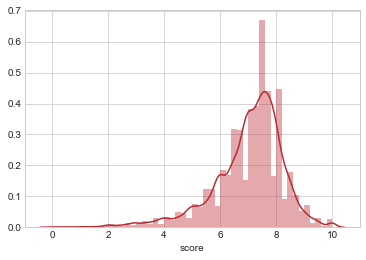

In [20]:
sns.distplot(df.score);

In [21]:
df[df['genre'] == "Rock"].score.mean()

6.987455089820416

In [22]:
df[df['genre'] == "Experimental"].score.mean()

7.355166163141978

In [23]:
df[df['genre'] == "Global"].score.mean()

7.432183908045976

In [24]:
df[df['genre'] == "Rap"].score.mean()

6.953127196064652

In [25]:
df[df['label'] == "Sub Pop"].score.mean()

7.1799256505576174

In [26]:
df[df['label'] != "Sub Pop"].score.mean()

7.015755752409556

__Spotify popularity__

Note: spike at 40 after having done global replacement of NaN with mean

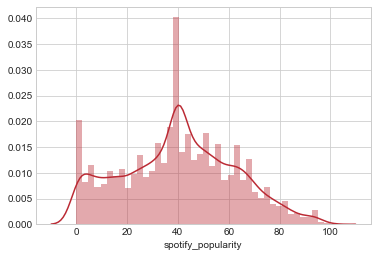

In [27]:
sns.distplot(df.spotify_popularity);

__Word count__

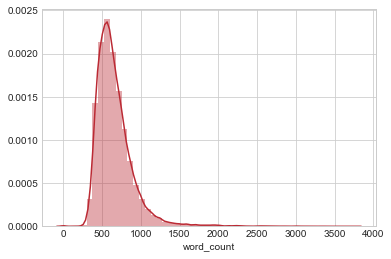

In [28]:
sns.distplot(df.word_count);

__Year__

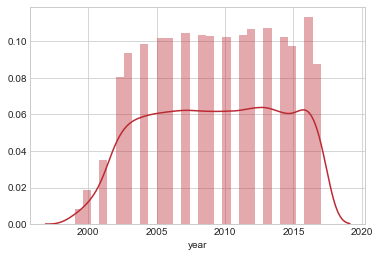

In [29]:
sns.distplot(df.year);

### Initial look at correlation between features

In [30]:
df.corr()

,score,word_count,year,author_review_count,total_number_releases,release_number,cum_mean_score,review_number,cum_mean_score_author,spotify_popularity
score,1.000000,0.233870,0.063463,-0.007041,0.104816,0.047886,0.509937,0.034775,0.363922,0.014039
word_count,0.233870,1.000000,0.150665,0.029233,0.205779,0.210551,0.128827,0.090238,0.105586,0.318325
year,0.063463,0.150665,1.000000,-0.050274,-0.051708,0.241706,0.022640,0.231897,0.068719,0.176347
author_review_count,-0.007041,0.029233,-0.050274,1.000000,0.021559,0.046122,0.004594,0.759193,-0.100916,-0.033215
total_number_releases,0.104816,0.205779,-0.051708,0.021559,1.000000,0.776384,0.086616,0.038403,0.029178,0.392485
release_number,0.047886,0.210551,0.241706,0.046122,0.776384,1.000000,0.047569,0.134690,0.022808,0.304714
cum_mean_score,0.509937,0.128827,0.022640,0.004594,0.086616,0.047569,1.000000,0.045381,0.203908,-0.026168
review_number,0.034775,0.090238,0.231897,0.759193,0.038403,0.134690,0.045381,1.000000,-0.023005,0.028269
cum_mean_score_author,0.363922,0.105586,0.068719,-0.100916,0.029178,0.022808,0.203908,-0.023005,1.000000,-0.052115
spotify_popularity,0.014039,0.318325,0.176347,-0.033215,0.392485,0.304714,-0.026168,0.028269,-0.052115,1.000000


In [31]:
df.corr().score.sort_values(ascending=False)

score                    1.000000
cum_mean_score           0.509937
cum_mean_score_author    0.363922
word_count               0.233870
total_number_releases    0.104816
year                     0.063463
release_number           0.047886
review_number            0.034775
spotify_popularity       0.014039
author_review_count     -0.007041
Name: score, dtype: float64

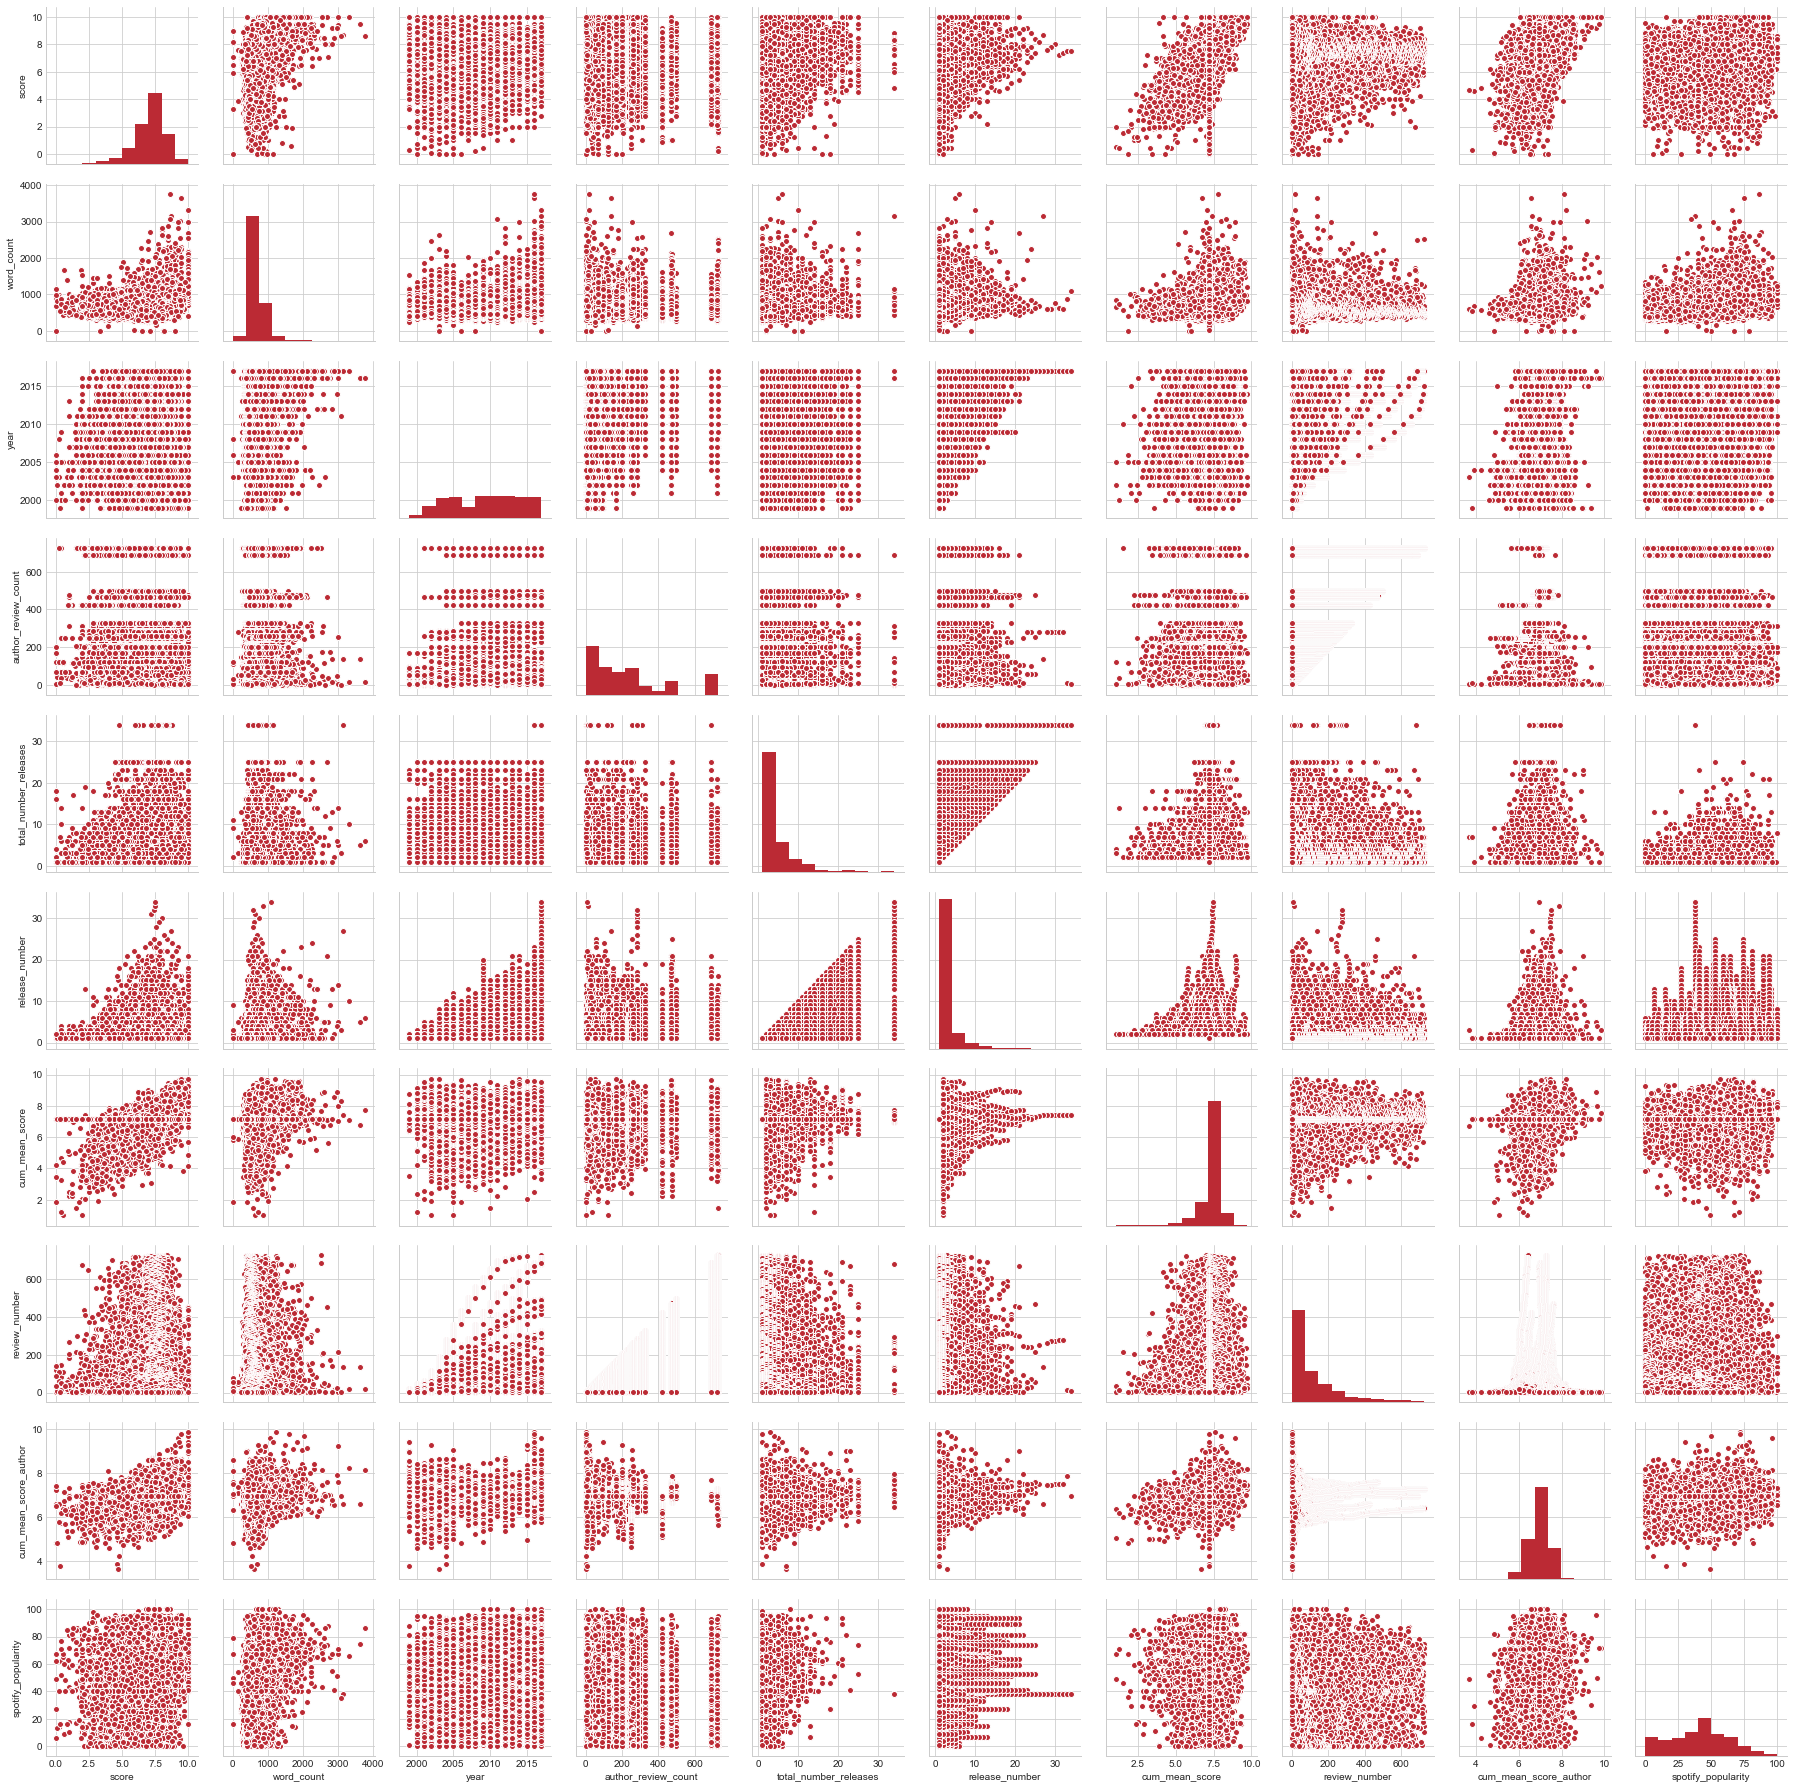

In [32]:
sns.pairplot(df);

### Look at correlations individually

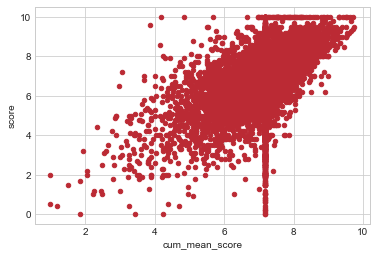

In [33]:
df.plot(kind='scatter', x='cum_mean_score', y='score');

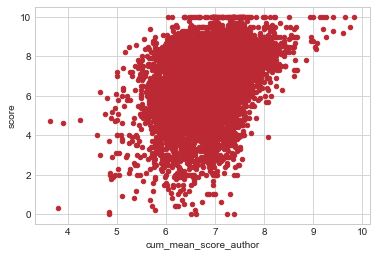

In [34]:
df.plot(kind='scatter', x='cum_mean_score_author', y='score');

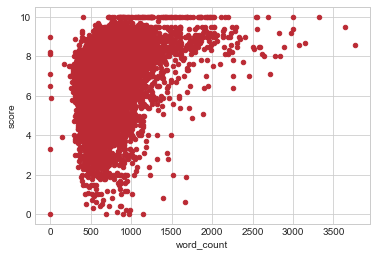

In [35]:
df.plot(kind='scatter', x='word_count', y='score');

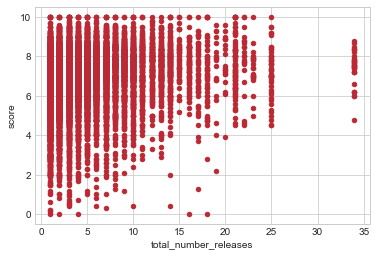

In [36]:
df.plot(kind='scatter', x='total_number_releases', y='score');

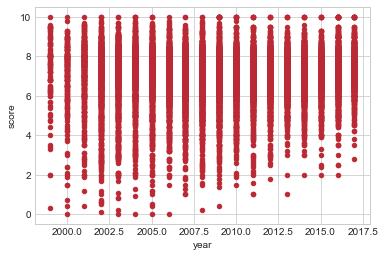

In [37]:
df.plot(kind='scatter', x='year', y='score');

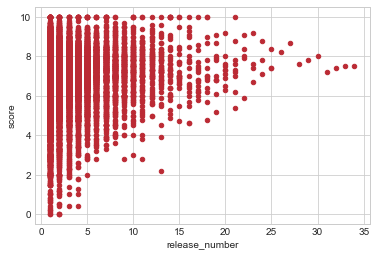

In [38]:
df.plot(kind='scatter', x='release_number', y='score');

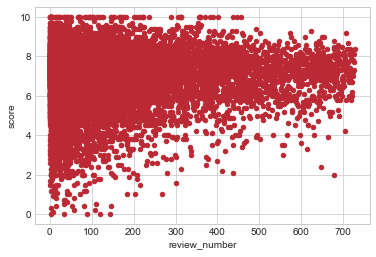

In [39]:
df.plot(kind='scatter', x='review_number', y='score');

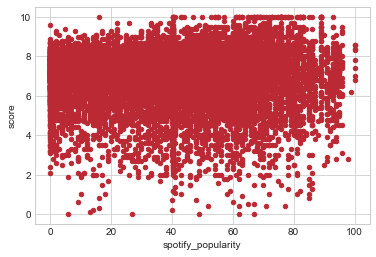

In [41]:
df.plot(kind='scatter', x='spotify_popularity', y='score');

__Look closely just at the highest rated Pitchfork albums.__

__Does that score carry over to Spotify?__

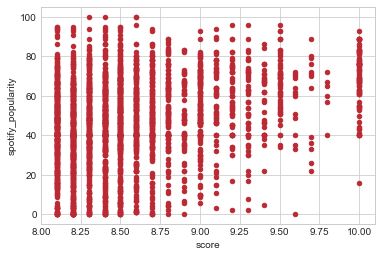

In [42]:
df[df.score > 8].plot(kind='scatter', x='score', y='spotify_popularity');

Nope!

### Create dummy variables from categorical variables

__[SKIP] Best New Music / Best New Reissue__

Note: I later decided NOT to include this feature since "best new music" is likely to be assigned AFTER a score is given.

In [ ]:
#df['best'] = np.where(df['bnm'] != 'None', 1.0, 0.0)

In [ ]:
#df.loc[df['bnm'] == "None"]

In [ ]:
#df = df.drop('best', axis=1)

__Record labels__

Sub Pop is the label with the most number of releases that have been reviewed by Pitchfork.  It is also claimed that Pitchfork favours this label over others.

In [99]:
df.label.value_counts(ascending=False).head()

Self-released    439
Sub Pop          269
Drag City        265
Thrill Jockey    234
Merge            232
Name: label, dtype: int64

In [100]:
df['subpop'] = np.where(df['label'] == 'Sub Pop', 1.0, 0.0)

Pitchfork is big on independent music

In [101]:
df['self_released'] = np.where(df['label'] == 'Self-released', 1.0, 0.0)

In [86]:
#df.loc[df['label'] == "Sub Pop"]

__Genre__

In [102]:
df.genre.value_counts(ascending=False)

Rock            6680
Electronic      3865
Experimental    1655
None            1615
Rap             1423
Pop/R&B         1129
Metal            750
Folk/Country     681
Jazz             246
Global           174
Name: genre, dtype: int64

In [103]:
X_genre = patsy.dmatrix('genre', data=df, return_type='dataframe')

In [104]:
X_genre.head()

,Intercept,genre[T.Experimental],genre[T.Folk/Country],genre[T.Global],genre[T.Jazz],genre[T.Metal],genre[T.None],genre[T.Pop/R&B],genre[T.Rap],genre[T.Rock]
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [105]:
df = df.join(X_genre)

In [106]:
df['genre[T.Electronic]'] = np.where(df['genre'] == 'Electronic', 1.0, 0.0)

In [ ]:
#df.head()

__Author title__

In [107]:
df.author_title.value_counts(ascending=False)

Contributor                  12878
None                          3133
Contributing Editor            566
Executive Editor               466
Senior Staff Writer            422
Senior Editor                  235
Deputy News Editor             104
Contributing Writer             88
Associate Staff Writer          81
Tracks Coordinator              70
Editor-in-Chief                 50
Associate Reviews Editor        46
Assistant Editor                29
Associate Editor                23
Associate Features Editor       16
Managing Editor                  6
News Director                    4
Contributor                      1
Name: author_title, dtype: int64

In [108]:
df['title[T.Contributor]'] = np.where(df['author_title'] == 'Contributor', 1.0, 0.0)

In [109]:
df['title[T.Contributing_Editor]'] = np.where(df['author_title'] == 'Contributing Editor', 1.0, 0.0)

In [110]:
df['title[T.Executive_Editor]'] = np.where(df['author_title'] == 'Executive Editor', 1.0, 0.0)

In [111]:
df['title[T.Senior_Staff_Writer]'] = np.where(df['author_title'] == 'Senior Staff Writer', 1.0, 0.0)

In [112]:
df['title[T.Senior_Editor]'] = np.where(df['author_title'] == 'Senior Editor', 1.0, 0.0)

__Year_binned__

In [113]:
df.year_binned.value_counts(ascending=False)

2010-2014    5695
2005-2009    5614
1999-2004    3656
2015-2017    3253
Name: year_binned, dtype: int64

In [114]:
df['1999-2004'] = np.where(df['year_binned'] == '1999-2004', 1.0, 0.0)

In [115]:
df['2005-2009'] = np.where(df['year_binned'] == '2005-2009', 1.0, 0.0)

In [116]:
df['2010-2014'] = np.where(df['year_binned'] == '2010-2014', 1.0, 0.0)

In [117]:
df['2015-2017'] = np.where(df['year_binned'] == '2015-2017', 1.0, 0.0)

### Rename columns (to work with Patsy)

In [118]:
df.columns

Index(['album', 'artist', 'author', 'author_title', 'bnm', 'genre', 'label',
       'score', 'word_count', 'year', 'pub_date_x_x', 'author_review_count',
       'total_number_releases', 'release_number', 'cum_mean_score',
       'review_number', 'cum_mean_score_author', 'spotify_popularity',
       'year_binned', 'subpop', 'self_released', 'Intercept',
       'genre[T.Experimental]', 'genre[T.Folk/Country]', 'genre[T.Global]',
       'genre[T.Jazz]', 'genre[T.Metal]', 'genre[T.None]', 'genre[T.Pop/R&B]',
       'genre[T.Rap]', 'genre[T.Rock]', 'genre[T.Electronic]',
       'title[T.Contributor]', 'title[T.Contributing_Editor]',
       'title[T.Executive_Editor]', 'title[T.Senior_Staff_Writer]',
       'title[T.Senior_Editor]', '1999-2004', '2005-2009', '2010-2014',
       '2015-2017'],
      dtype='object')

Temporarily rename columns for Patsy

In [65]:
#df.rename(columns={'genre[T.Experimental]': 'G_experimental', 'genre[T.Folk/Country]': 'G_folk_country', 'genre[T.Global]': 'G_global',
       'genre[T.Jazz]': 'G_jazz', 'genre[T.Metal]': 'G_metal', 'genre[T.None]': 'G_none', 'genre[T.Pop/R&B]': 'G_pop_rb',
       'genre[T.Rap]': 'G_rap', 'genre[T.Rock]': 'G_rock', 'genre[T.Electronic]': 'G_electronic',
       'title[T.Contributor]': 'A_contributor', 'title[T.Contributing_Editor]': 'A_contributing_editor',
       'title[T.Executive_Editor]': 'A_exec_editor', 'title[T.Senior_Staff_Writer]': 'A_senior_staff_writer',
       'title[T.Senior_Editor]': 'A_senior_editor', '1999-2004': 'Y_99_04', '2005-2009': 'Y_05_09', '2010-2014': 'Y_10_14',
       '2015-2017': 'Y_15_17'}, inplace=True)

In [66]:
yf1, Xf1 = patsy.dmatrices('score ~ word_count + author_review_count + total_number_releases + release_number + cum_mean_score + review_number + cum_mean_score_author + spotify_popularity + subpop + self_released + G_experimental + G_folk_country + G_global + G_jazz + G_metal + G_pop_rb + G_rap + G_rock + G_electronic + A_contributor + A_contributing_editor + A_exec_editor + A_senior_staff_writer + A_senior_editor + Y_99_04 + Y_05_09 + Y_10_14 + Y_15_17', data=df, return_type="dataframe")


In [67]:
model_f1 = sm.OLS(yf1, Xf1)
fit_f1 = model_f1.fit()
fit_f1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     383.1
Date:                Mon, 09 Oct 2017   Prob (F-statistic):               0.00
Time:                        20:50:51   Log-Likelihood:                -26100.
No. Observations:               18218   AIC:                         5.226e+04
Df Residuals:                   18190   BIC:                         5.247e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -3.3083      0.110    -29.966      0.000      -3.525      -3.092
word_count                0.0008   3.41e-05     23.632      0.000       0.001       0.001
author_review_count       0.0002   6.32e-05      3.754      0.000       0.000       0.000
total_number_releases     0.0436      0.003     12.834      0.000       0.037       0.050
release_number           -0.0611      0.005    -11.955      0.000      -0.071      -0.051
cum_mean_score            0.7963      0.011     69.448      0.000       0.774       0.819
review_number            -0.0003   9.13e-05     -2.752      0.006      -0.000   -7.23e-05
cum_mean_score_author     0.7023      0.017     40.298      0.000       0.668       0.737
spotify_popularity       -0.0021      0.000     -4.984      0.000      -0.003      -0.001
subpop                    0.0588      0.063      0.940      0.347      -0.064       0.181
self_released            -0.0339      0.051     -0.670      0.503      -0.133       0.065
G_experimental            0.1798      0.036      4.951      0.000       0.109       0.251
G_folk_country            0.1828      0.047      3.889      0.000       0.091       0.275
G_global                  0.1925      0.082      2.354      0.019       0.032       0.353
G_jazz                    0.2288      0.070      3.268      0.001       0.092       0.366
G_metal                   0.0533      0.045      1.177      0.239      -0.036       0.142
G_pop_rb                  0.0912      0.041      2.248      0.025       0.012       0.171
G_rap                     0.0678      0.040      1.702      0.089      -0.010       0.146
G_rock                    0.1117      0.029      3.797      0.000       0.054       0.169
G_electronic              0.0603      0.031      1.953      0.051      -0.000       0.121
A_contributor            -0.0492      0.022     -2.188      0.029      -0.093      -0.005
A_contributing_editor    -0.1533      0.050     -3.054      0.002      -0.252      -0.055
A_exec_editor            -0.1547      0.054     -2.861      0.004      -0.261      -0.049
A_senior_staff_writer     0.1139      0.055      2.083      0.037       0.007       0.221
A_senior_editor           0.1080      0.070      1.547      0.122      -0.029       0.245
Y_99_04                  -0.9759      0.032    -30.466      0.000      -1.039      -0.913
Y_05_09                  -0.8758      0.030    -28.910      0.000      -0.935      -0.816
Y_10_14                  -0.7458      0.030    -25.015      0.000      -0.804      -0.687
Y_15_17                  -0.7108      0.035    -20.581      0.000      -0.779      -0.643
==============================================================================
Omnibus:                     4472.243   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarqu

__Try dropping some features__

In [68]:
yf2, Xf2 = patsy.dmatrices('score ~ word_count + author_review_count + total_number_releases + release_number + cum_mean_score + review_number + cum_mean_score_author + spotify_popularity + G_experimental + G_folk_country + G_global + G_jazz + G_metal + G_pop_rb + G_rap + G_rock + G_electronic + A_contributor + A_contributing_editor + A_exec_editor + A_senior_staff_writer + A_senior_editor + Y_99_04 + Y_05_09 + Y_10_14 + Y_15_17', data=df, return_type="dataframe")


In [69]:
model_f2 = sm.OLS(yf2, Xf2)
fit_f2 = model_f2.fit()
#fit_f2.summary()
fit_f2.rsquared_adj

0.36155833387599634

In [70]:
yf3, Xf3 = patsy.dmatrices('score ~ word_count + author_review_count + total_number_releases + release_number + cum_mean_score + review_number + cum_mean_score_author + spotify_popularity + G_experimental + G_folk_country + G_global + G_jazz + G_pop_rb + G_rap + G_rock + G_electronic + A_contributor + A_contributing_editor + A_exec_editor + A_senior_staff_writer + A_senior_editor + Y_99_04 + Y_05_09 + Y_10_14 + Y_15_17', data=df, return_type="dataframe")


In [71]:
model_f3 = sm.OLS(yf3, Xf3)
fit_f3 = model_f3.fit()
#fit_f3.summary()
fit_f3.rsquared_adj

0.36154319955779324

In [72]:
yf4, Xf4 = patsy.dmatrices('score ~ word_count + release_number + cum_mean_score + cum_mean_score_author + spotify_popularity + G_experimental + G_folk_country + G_global + G_jazz + G_pop_rb + G_rap + G_rock + G_electronic + A_contributor + A_contributing_editor + A_exec_editor + A_senior_staff_writer + A_senior_editor + Y_99_04 + Y_05_09 + Y_10_14 + Y_15_17', data=df, return_type="dataframe")


In [73]:
model_f4 = sm.OLS(yf4, Xf4)
fit_f4 = model_f4.fit()
#fit_f4.summary()
fit_f4.rsquared_adj

0.35547053181444077

In [74]:
yf5, Xf5 = patsy.dmatrices('score ~ word_count + release_number + cum_mean_score + cum_mean_score_author + G_experimental + G_folk_country + G_global + G_jazz + G_pop_rb + G_rap + G_rock + G_electronic + A_contributing_editor + A_exec_editor + A_senior_staff_writer + A_senior_editor + Y_99_04 + Y_05_09 + Y_10_14 + Y_15_17', data=df, return_type="dataframe")


In [75]:
model_f5 = sm.OLS(yf5, Xf5)
fit_f5 = model_f5.fit()
#fit_f5.summary()
fit_f5.rsquared_adj

0.35549191358600596

In [76]:
yf6, Xf6 = patsy.dmatrices('score ~ word_count + release_number + cum_mean_score + cum_mean_score_author + G_experimental + G_global', data=df, return_type="dataframe")




In [77]:
model_f6 = sm.OLS(yf6, Xf6)
fit_f6 = model_f6.fit()
#fit_f6.summary()
fit_f6.rsquared_adj

0.35315089053426274

In [78]:
yf7, Xf7 = patsy.dmatrices('score ~ word_count + release_number + cum_mean_score + cum_mean_score_author + G_experimental', data=df, return_type="dataframe")



In [79]:
model_f7 = sm.OLS(yf7, Xf7)
fit_f7 = model_f7.fit()
#fit_f7.summary()
fit_f7.rsquared_adj

0.35314756756488008

In [80]:
yf8, Xf8 = patsy.dmatrices('score ~ word_count + release_number + cum_mean_score + cum_mean_score_author', data=df, return_type="dataframe")



In [81]:
model_f8 = sm.OLS(yf8, Xf8)
fit_f8 = model_f8.fit()
#fit_f8.summary()
fit_f8.rsquared_adj

0.35252931667489207

### Have another look at correlations

In [ ]:
#df.corr()

In [119]:
df.corr().score.sort_values(ascending=False)

score                           1.000000
cum_mean_score                  0.509937
cum_mean_score_author           0.363922
word_count                      0.233870
total_number_releases           0.104816
genre[T.Experimental]           0.083896
2015-2017                       0.078075
title[T.Executive_Editor]       0.073230
year                            0.063463
genre[T.Jazz]                   0.049978
release_number                  0.047886
title[T.Contributing_Editor]    0.042585
review_number                   0.034775
genre[T.Global]                 0.032019
genre[T.Folk/Country]           0.030110
title[T.Contributor]            0.023542
subpop                          0.015595
spotify_popularity              0.014039
2010-2014                       0.004333
title[T.Senior_Editor]          0.004033
author_review_count            -0.007041
genre[T.Metal]                 -0.009625
1999-2004                      -0.009776
self_released                  -0.010876
genre[T.Pop/R&B]

In [120]:
df.columns

Index(['album', 'artist', 'author', 'author_title', 'bnm', 'genre', 'label',
       'score', 'word_count', 'year', 'pub_date_x_x', 'author_review_count',
       'total_number_releases', 'release_number', 'cum_mean_score',
       'review_number', 'cum_mean_score_author', 'spotify_popularity',
       'year_binned', 'subpop', 'self_released', 'Intercept',
       'genre[T.Experimental]', 'genre[T.Folk/Country]', 'genre[T.Global]',
       'genre[T.Jazz]', 'genre[T.Metal]', 'genre[T.None]', 'genre[T.Pop/R&B]',
       'genre[T.Rap]', 'genre[T.Rock]', 'genre[T.Electronic]',
       'title[T.Contributor]', 'title[T.Contributing_Editor]',
       'title[T.Executive_Editor]', 'title[T.Senior_Staff_Writer]',
       'title[T.Senior_Editor]', '1999-2004', '2005-2009', '2010-2014',
       '2015-2017'],
      dtype='object')

## Begin modeling...
### First, define y and X

__Keep: word count, year, release number, cum mean score, cum mean score author, subpop, genres....__

In [121]:
y = df.score
x = df.drop(['album', 'artist', 'author', 'author_title', 'bnm', 'genre', 'label',
       'score', 'year', 'pub_date_x_x', 'author_review_count',
       'total_number_releases', 'review_number', 'year_binned',
       'Intercept', 'genre[T.None]'],1)

In [122]:
x.columns

Index(['word_count', 'release_number', 'cum_mean_score',
       'cum_mean_score_author', 'spotify_popularity', 'subpop',
       'self_released', 'genre[T.Experimental]', 'genre[T.Folk/Country]',
       'genre[T.Global]', 'genre[T.Jazz]', 'genre[T.Metal]',
       'genre[T.Pop/R&B]', 'genre[T.Rap]', 'genre[T.Rock]',
       'genre[T.Electronic]', 'title[T.Contributor]',
       'title[T.Contributing_Editor]', 'title[T.Executive_Editor]',
       'title[T.Senior_Staff_Writer]', 'title[T.Senior_Editor]', '1999-2004',
       '2005-2009', '2010-2014', '2015-2017'],
      dtype='object')

In [123]:
x.head()

,word_count,release_number,cum_mean_score,cum_mean_score_author,spotify_popularity,subpop,self_released,genre[T.Experimental],genre[T.Folk/Country],genre[T.Global],...,genre[T.Electronic],title[T.Contributor],title[T.Contributing_Editor],title[T.Executive_Editor],title[T.Senior_Staff_Writer],title[T.Senior_Editor],1999-2004,2005-2009,2010-2014,2015-2017
0,1409,5,8.020000,8.072222,40.241964,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2304,1,7.167176,8.175000,44.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1091,1,7.167176,7.550781,41.000000,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,842,2,8.000000,6.962325,64.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,794,6,6.883333,7.059155,45.000000,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [124]:
X = preprocessing.normalize(x, axis=0, norm='max')
X = pd.DataFrame(X)
X.columns = x.columns

Do not need to normalize y since it is normally distributed.

In [125]:
X.columns

Index(['word_count', 'release_number', 'cum_mean_score',
       'cum_mean_score_author', 'spotify_popularity', 'subpop',
       'self_released', 'genre[T.Experimental]', 'genre[T.Folk/Country]',
       'genre[T.Global]', 'genre[T.Jazz]', 'genre[T.Metal]',
       'genre[T.Pop/R&B]', 'genre[T.Rap]', 'genre[T.Rock]',
       'genre[T.Electronic]', 'title[T.Contributor]',
       'title[T.Contributing_Editor]', 'title[T.Executive_Editor]',
       'title[T.Senior_Staff_Writer]', 'title[T.Senior_Editor]', '1999-2004',
       '2005-2009', '2010-2014', '2015-2017'],
      dtype='object')

In [126]:
X.head()

,word_count,release_number,cum_mean_score,cum_mean_score_author,spotify_popularity,subpop,self_released,genre[T.Experimental],genre[T.Folk/Country],genre[T.Global],...,genre[T.Electronic],title[T.Contributor],title[T.Contributing_Editor],title[T.Executive_Editor],title[T.Senior_Staff_Writer],title[T.Senior_Editor],1999-2004,2005-2009,2010-2014,2015-2017
0,0.374734,0.147059,0.822564,0.820904,0.40242,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.612766,0.029412,0.735095,0.831356,0.44000,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.290160,0.029412,0.735095,0.767876,0.41000,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.223936,0.058824,0.820513,0.708033,0.64000,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.211170,0.176471,0.705983,0.717880,0.45000,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Baseline R2

In [127]:
baseline = LinearRegression()
baseline.fit(X,y)
baseline.score(X,y)

0.35630756675230835

__Try dropping a few features that were negatively correlated__

In [128]:
X.columns

Index(['word_count', 'release_number', 'cum_mean_score',
       'cum_mean_score_author', 'spotify_popularity', 'subpop',
       'self_released', 'genre[T.Experimental]', 'genre[T.Folk/Country]',
       'genre[T.Global]', 'genre[T.Jazz]', 'genre[T.Metal]',
       'genre[T.Pop/R&B]', 'genre[T.Rap]', 'genre[T.Rock]',
       'genre[T.Electronic]', 'title[T.Contributor]',
       'title[T.Contributing_Editor]', 'title[T.Executive_Editor]',
       'title[T.Senior_Staff_Writer]', 'title[T.Senior_Editor]', '1999-2004',
       '2005-2009', '2010-2014', '2015-2017'],
      dtype='object')

In [129]:
X2 = X.drop(['self_released', 'genre[T.Metal]',
       'genre[T.Pop/R&B]', 'genre[T.Rap]', 'genre[T.Rock]',
       'genre[T.Electronic]','title[T.Senior_Staff_Writer]', '1999-2004',
       '2005-2009'],1)

In [130]:
X2.columns

Index(['word_count', 'release_number', 'cum_mean_score',
       'cum_mean_score_author', 'spotify_popularity', 'subpop',
       'genre[T.Experimental]', 'genre[T.Folk/Country]', 'genre[T.Global]',
       'genre[T.Jazz]', 'title[T.Contributor]', 'title[T.Contributing_Editor]',
       'title[T.Executive_Editor]', 'title[T.Senior_Editor]', '2010-2014',
       '2015-2017'],
      dtype='object')

In [131]:
baseline2 = LinearRegression()
baseline2.fit(X2,y)
baseline2.score(X2,y)

0.35473991523886728

Not as good - stick with X for meantime.

## Test-train split

In [139]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

model_tt= LinearRegression()
model_tt.fit(X_train,y_train)

print(f"train R2: {model_tt.score(X_train,y_train)}, "
      f"test R2: {model_tt.score(X_test,y_test)}")

train R2: 0.3495795486197678, test R2: 0.37127401125755


In [133]:
z = list(zip(list(X_train.columns), model_tt.coef_))
features = sorted(z, key=lambda t: t[1], reverse=True)
features

[('cum_mean_score', 0.81242876954088539),
 ('cum_mean_score_author', 0.72369084663742744),
 ('genre[T.Experimental]', 0.19298743538448843),
 ('title[T.Senior_Staff_Writer]', 0.18785154615922825),
 ('genre[T.Folk/Country]', 0.18733092175574939),
 ('genre[T.Global]', 0.14849804839789332),
 ('genre[T.Jazz]', 0.11303869249349302),
 ('title[T.Senior_Editor]', 0.11204456354680203),
 ('genre[T.Rock]', 0.10804104745182455),
 ('genre[T.Rap]', 0.067851680480047305),
 ('genre[T.Pop/R&B]', 0.061932866255303975),
 ('2010-2014', 0.05762157806957012),
 ('genre[T.Metal]', 0.046094586909667765),
 ('genre[T.Electronic]', 0.041190471029118159),
 ('subpop', 0.036681096280042916),
 ('2015-2017', 0.014782762557622398),
 ('word_count', 0.00082393485065257292),
 ('spotify_popularity', -0.00015442896728712352),
 ('self_released', -0.003723210425990886),
 ('release_number', -0.011845634971161693),
 ('title[T.Contributor]', -0.012218447514038472),
 ('2005-2009', -0.016187019052166574),
 ('1999-2004', -0.05621732

## Cross validation

In [ ]:
alpha = 0.05

sig_cols = [
    c for c in X.columns
    if f_select.f_regression(X[[c]], y)[1][0] < alpha
]

X_sig = X[sig_cols]

In [ ]:
sig_cols

In [ ]:
est_cv = LinearRegression()
cross_val_score(est_cv, X_sig, y, cv=5, scoring="r2").mean()

__Features selection function:__

In [134]:
def find_sig_cols(X, y, alpha=0.05):
    sig_cols = []
    for c in X.columns:
        pvalue = f_select.f_regression(X[[c]], y)[1][0]
        if pvalue <= alpha:
            sig_cols.append(c)

    return sig_cols

In [137]:
kf = KFold(n=len(X), n_folds=5, shuffle=True)
est_cv2 = LinearRegression()

all_scores = []

for train_i, test_i in kf:
    x_train = X.iloc[train_i]
    y_train = y.iloc[train_i].reshape(-1, 1)
    x_test = X.iloc[test_i]
    y_test = y.iloc[test_i].reshape(-1, 1)

    sig_cols = find_sig_cols(x_train, y_train)
    est_cv2.fit(x_train[sig_cols], y_train)
    r2 = est_cv2.score(x_test[sig_cols], y_test)
    all_scores.append(r2)

np.mean(all_scores)

0.35358020108117627

## Regularization

### Ridge regression

In [140]:
est_r1 = Ridge()
est_r1.fit(X_train, y_train)
est_r1.score(X_test, y_test)

0.37126858244161698

In [ ]:
#est_r1.coef_

In [141]:
zipped = list(zip(list(X_train.columns), est_r1.coef_))
features = sorted(zipped, key=lambda t: t[1], reverse=True)
features

[('cum_mean_score', 0.80864033842749916),
 ('cum_mean_score_author', 0.70174636704017779),
 ('genre[T.Jazz]', 0.20230086973460049),
 ('genre[T.Experimental]', 0.19175639679003945),
 ('title[T.Senior_Staff_Writer]', 0.19133332799523001),
 ('genre[T.Folk/Country]', 0.17268864632938605),
 ('title[T.Senior_Editor]', 0.14657983659121104),
 ('genre[T.Rock]', 0.11621638400486826),
 ('genre[T.Global]', 0.11046601017195178),
 ('genre[T.Metal]', 0.060953031784171892),
 ('2010-2014', 0.042895841710315637),
 ('genre[T.Pop/R&B]', 0.039147228795317526),
 ('genre[T.Rap]', 0.030920890029793001),
 ('2015-2017', 0.029594825781287189),
 ('title[T.Contributor]', 0.027517580342305226),
 ('genre[T.Electronic]', 0.020160286497856898),
 ('self_released', 0.0049739160228164702),
 ('word_count', 0.00081303906110175104),
 ('spotify_popularity', -0.00025993216990844549),
 ('release_number', -0.0077888743836337137),
 ('2005-2009', -0.013227302128375315),
 ('subpop', -0.017752116356782741),
 ('title[T.Contributing_

In [142]:
rcv = RidgeCV(alphas=(0.1, 1.0, 10.0, 0.0, 1e-8, 1e-5, 1e-1),cv=10)
rcv.fit(X_train, y_train)
rcv.score(X_test, y_test)

0.37121973656966256

In [143]:
rcv.alpha_

10.0

## Lasso regression

In [144]:
est_l1 = Lasso()
est_l1.fit(X_train, y_train)
est_l1.score(X_test, y_test)

0.054667767004592416

In [145]:
lcv = LassoCV(alphas=(0.1, 1.0, 10.0, 0.0, 1e-8, 1e-5, 1e-1),cv=10)
lcv.fit(X_train, y_train)
lcv.score(X_test, y_test)

0.37126763254210593

In [146]:
lcv.alpha_

1.0000000000000001e-05

## Polynomial features

__Degree: 2__

In [147]:
est_p2 = make_pipeline(PolynomialFeatures(2), LinearRegression())
est_p2.fit(X_train, y_train)
est_p2.score(X_test, y_test)

0.37225295271600212

__Degree: 3__

In [ ]:
#est_p3 = make_pipeline(PolynomialFeatures(3), LinearRegression())
#est_p3.fit(X_train, y_train)
#est_p3.score(X_test, y_test)

## Create dataframe columns for 'predicted score' and 'residual'

In [148]:
df['predicted_score'] = model_tt.predict(x)

In [149]:
df['residual'] = df['predicted_score'] - df['score']

In [ ]:
#df.loc[df['score'] < 5][['artist', 'album', 'release_number', 'cum_mean_score', 'cum_mean_score_author', 'score', 'predicted_score', 'residual']].sort_values('residual', ascending=False)




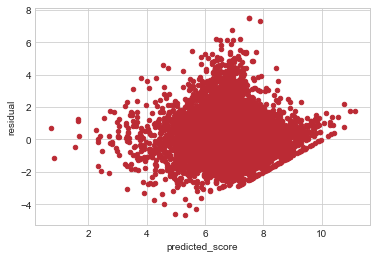

In [150]:
df.plot(kind='scatter', x='predicted_score', y='residual');

In [152]:
mask_debut = (df['release_number'] == 1)
mask_soph = (df['release_number'] > 1)

(0, 10)

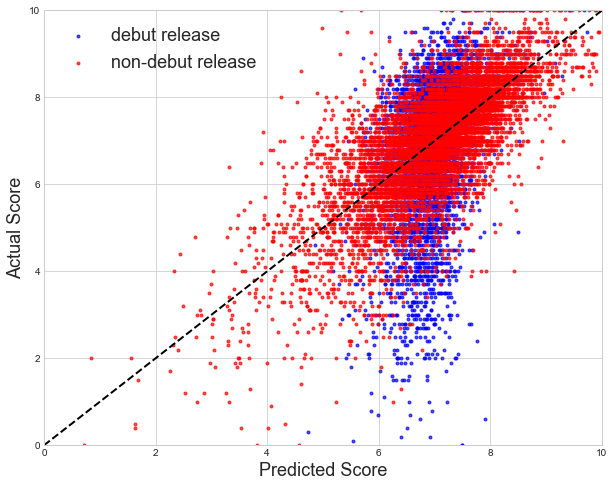

In [153]:
a = range(11)
b = range(11)

plt.figure(figsize=(10,8))
plt.scatter(df[mask_debut]['predicted_score'], df[mask_debut]['score'], marker='.', alpha=0.7, color='b', label='debut release')
plt.scatter(df[mask_soph]['predicted_score'], df[mask_soph]['score'], marker='.', alpha=0.7, color='r', label='non-debut release')
plt.plot(a, b, 'r--', linewidth=2, color='black')
plt.legend(loc='upper left', fontsize=18)
#plt.title('Model Performance', fontsize=18)
plt.ylabel('Actual Score', fontsize=18)
plt.xlabel('Predicted Score', fontsize=18)
plt.xlim(0, 10)
plt.ylim(0, 10)

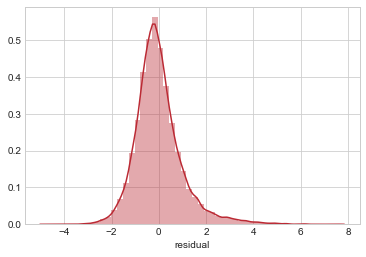

In [154]:
sns.distplot(df.residual);

In [157]:
mask_debut = (df['release_number'] == 1)

In [158]:
mask_notdebut = (df['release_number'] > 1)

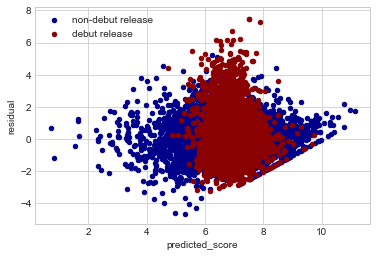

In [159]:
ax = df[mask_notdebut].plot(kind='scatter', x='predicted_score', y='residual', color='DarkBlue', label='non-debut release');

df[mask_debut].plot(kind='scatter', x='predicted_score', y='residual', color='DarkRed', label='debut release', ax=ax);


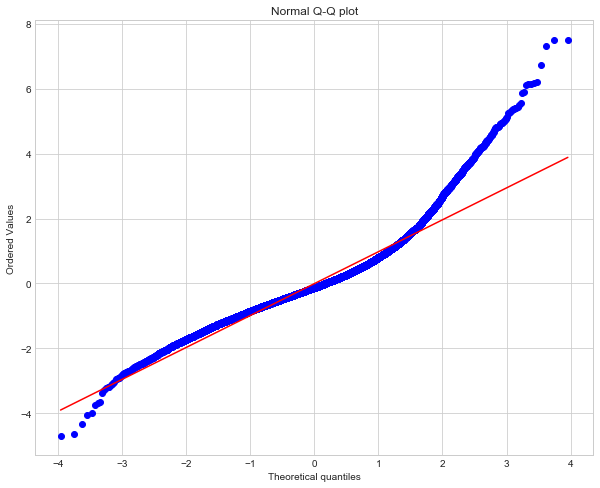

In [161]:
import scipy.stats as stats
res = df['residual']
plt.figure(figsize=(10,8))
stats.probplot(res, dist="norm", plot=plt)
plt.title("Normal Q-Q plot");